  # Suicide Risk Detection: A Comprehensive Analysis
 # **Research Project Notebook**
 ## Table of Contents
 1. [Introduction](#introduction)
 2. [Setup and Libraries](#setup)
 3. [Data Loading and Initial Inspection](#loading)
 4. [Exploratory Data Analysis (EDA) & Visualization](#eda)
     - 4.1. [Class Distribution](#class-distribution)
     - 4.2. [Text Preprocessing](#text-preprocessing-func)
     - 4.3. [Text Length and Word Count Analysis](#text-length-word-count)
     - 4.4. [Sentiment Analysis](#sentiment-analysis)
     - 4.5. [Word Clouds](#word-clouds)
     - 4.6. [N-gram Analysis](#ngram-analysis)
     - 4.7. [Engineered Feature Analysis](#engineered-features)
 5. [Data Pre-treatment for Modeling](#data-pretreatment)
     - 5.1. [Train-Test Split](#train-test-split)
     - 5.2. [Feature Extraction for Classical Models (TF-IDF)](#tfidf)
     - 5.3. [Data Preparation for Keras Deep Learning Models](#keras-prep)
     - 5.4. [Data Preparation for BERT (PyTorch)](#bert-prep)
 6. [Classical Machine Learning Models](#classical-models)
     - 6.1. [Logistic Regression](#logistic-regression)
     - 6.2. [Support Vector Machine (SVM)](#svm)
     - 6.3. [Random Forest](#random-forest)
     - 6.4. [K-Nearest Neighbors (KNN)](#knn)
 7. [Deep Learning Models](#deep-learning-models)
     - 7.1. [Simple RNN](#simple-rnn)
     - 7.2. [GRU (Gated Recurrent Unit)](#gru)
     - 7.3. [LSTM (Long Short-Term Memory)](#lstm)
     - 7.4. [BERT (Bidirectional Encoder Representations from Transformers)](#bert)
     - 7.5. [Hybrid Deep Learning Models](#hybrid-models)
         - 7.5.1. [CNN-LSTM](#cnn-lstm)
         - 7.5.2. [CNN-GRU](#cnn-gru)
         - 7.5.3. [BERT + LSTM (Conceptual - Using BERT Embeddings)](#bert-lstm)
 8. [Results and Comparison](#results-comparison)
 9. [Model Saving (BERT Example)](#model-saving)
 10. [Prediction on New Text (Using Best Model - BERT)](#prediction-example)
 11. [Discussion](#discussion)
 12. [Conclusion](#conclusion)
 13. [Future Work](#future-work)
 14. [Ethical Considerations and Disclaimer](#disclaimer)


---
<a id="introduction"></a>
## 1. Introduction
Suicide is a critical public health issue worldwide. Early detection of suicide risk can play a vital role in prevention efforts. Social media platforms and online forums have become spaces where individuals express their thoughts and feelings, including those indicative of suicidal ideation. This project aims to leverage Natural Language Processing (NLP) and Machine Learning (ML) techniques to automatically detect suicide risk from text data.
 **Objective:**
 The primary objective of this notebook is to explore, implement, and compare various machine learning and deep learning models for the task of suicide risk detection using a publicly available dataset. We will perform comprehensive data analysis, preprocessing, feature engineering, model training, and evaluation.
 **Models to be Explored:**
 - **Classical ML:** Logistic Regression, SVM, Random Forest, KNN.
 - **Deep Learning:** Simple RNN, GRU, LSTM, BERT.
 - **Hybrid DL:** CNN-LSTM, CNN-GRU, (conceptual) BERT-LSTM.
 This notebook will follow a structured research approach, documenting each step from data ingestion to model interpretation.

---
<a id="setup"></a>
## 2. Setup and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import os
import warnings
warnings.filterwarnings('ignore')

#Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
tf.random.set_seed(42)

#Check if GPU is available (for PyTorch)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using PyTorch device: {device}")

#Check GPU availability for TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"TensorFlow: {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs available.")
    except RuntimeError as e:
        print(e)
else:
    print("TensorFlow: No GPU available, using CPU.")


#Download NLTK resources
import nltk
import os
import subprocess # For running shell commands like wget and unzip
import zipfile

# Define a custom NLTK data directory within the writable /kaggle/working/ area
custom_nltk_data_dir = "/kaggle/working/nltk_data"
if not os.path.exists(custom_nltk_data_dir):
    os.makedirs(custom_nltk_data_dir)
    print(f"Created custom NLTK data directory: {custom_nltk_data_dir}")

# Prepend the custom directory to NLTK's data path
if custom_nltk_data_dir not in nltk.data.path:
    nltk.data.path.insert(0, custom_nltk_data_dir)
    print(f"Added {custom_nltk_data_dir} to nltk.data.path. Current path: {nltk.data.path}")
else:
    print(f"{custom_nltk_data_dir} already in nltk.data.path. Current path: {nltk.data.path}")

# --- Manual Download and Unzip Function ---
def download_and_unzip_nltk_resource(resource_name, zip_url, target_subdir, expected_find_path):
    print(f"\nAttempting to manually download and install NLTK resource: {resource_name}")
    
    # Define paths
    zip_filename = os.path.basename(zip_url)
    zip_filepath = os.path.join(custom_nltk_data_dir, zip_filename)
    extraction_path = os.path.join(custom_nltk_data_dir, target_subdir) # e.g., /kaggle/working/nltk_data/corpora

    if not os.path.exists(extraction_path):
        os.makedirs(extraction_path, exist_ok=True)
        print(f"Created extraction subdirectory: {extraction_path}")

    try:
        # Check if already successfully downloaded and unzipped (by checking expected_find_path)
        nltk.data.find(expected_find_path)
        print(f"Resource '{resource_name}' seems to be already available at '{expected_find_path}'. Skipping manual download.")
        return True
    except LookupError:
        print(f"Resource '{resource_name}' not found by nltk.data.find('{expected_find_path}'). Proceeding with manual download.")

    # 1. Download using wget
    print(f"Downloading {zip_url} to {zip_filepath}...")
    try:
        subprocess.run(['wget', '-q', zip_url, '-O', zip_filepath], check=True)
        print("Download successful.")
    except subprocess.CalledProcessError as e:
        print(f"ERROR: wget download failed for {resource_name}. Error: {e}")
        return False
    except FileNotFoundError:
        print("ERROR: wget command not found. This method might not work in this environment if wget isn't available.")
        return False

    # 2. Unzip
    print(f"Unzipping {zip_filepath} to {extraction_path}...")
    try:
        with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
            zip_ref.extractall(extraction_path)
        print("Unzipping successful.")
        # Some NLTK resources expect the unzipped folder to have the resource name
        # e.g., wordnet.zip unzips to a 'wordnet' folder.
        # Ensure the final folder structure is what NLTK expects (e.g., corpora/wordnet, sentiment/vader_lexicon)
        
        # Verify if NLTK can find it now
        nltk.data.find(expected_find_path)
        print(f"NLTK can now find '{resource_name}' at '{expected_find_path}' after manual extraction.")
        
        # Clean up the zip file
        os.remove(zip_filepath)
        print(f"Cleaned up {zip_filepath}.")
        return True
        
    except zipfile.BadZipFile:
        print(f"ERROR: BadZipFile for {resource_name}. The downloaded file might be corrupted or not a zip file.")
        if os.path.exists(zip_filepath): os.remove(zip_filepath) # Clean up bad zip
        return False
    except Exception as e:
        print(f"ERROR: Unzipping failed for {resource_name}. Error: {e}")
        if os.path.exists(zip_filepath): os.remove(zip_filepath) # Clean up zip if unzipping failed
        return False


# --- NLTK Resources to handle manually/verify ---
# URLs are from the NLTK data index: https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
# The target_subdir is relative to custom_nltk_data_dir (e.g., corpora, sentiment)
# The expected_find_path is what nltk.data.find() uses (e.g., corpora/wordnet)

resources_to_manage = [
    {
        "name": "stopwords",
        "zip_url": "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/stopwords.zip",
        "target_subdir": "corpora",
        "expected_find_path": "corpora/stopwords" # NLTK expects to find the 'stopwords' dir here
    },
    {
        "name": "wordnet",
        "zip_url": "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/wordnet.zip",
        "target_subdir": "corpora", # wordnet.zip will extract a 'wordnet' folder into 'corpora'
        "expected_find_path": "corpora/wordnet"
    },
    {
        "name": "omw-1.4",
        "zip_url": "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/omw-1.4.zip",
        "target_subdir": "corpora", # omw-1.4.zip will extract an 'omw-1.4' folder into 'corpora'
        "expected_find_path": "corpora/omw-1.4"
    },
    {
        "name": "punkt",
        "zip_url": "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/tokenizers/punkt.zip",
        "target_subdir": "tokenizers",
        "expected_find_path": "tokenizers/punkt"
    },
    {
        "name": "vader_lexicon",
        "zip_url": "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/sentiment/vader_lexicon.zip",
        "target_subdir": "sentiment", # vader_lexicon.zip will extract a 'vader_lexicon' folder into 'sentiment'
        "expected_find_path": "sentiment/vader_lexicon.zip/vader_lexicon/" # NLTK's find path for vader is a bit specific
                                                                         # Or sometimes just sentiment/vader_lexicon
    }
]

print("\nProcessing NLTK resources (manual download if necessary)...")
all_resources_ok = True
for res_info in resources_to_manage:
    # Adjust expected_find_path for vader_lexicon for the initial check by nltk.data.find
    # The actual find path for vader might be simpler after extraction.
    # We are providing the path that nltk.data.find expects.
    # For vader, after unzipping, it usually creates sentiment/vader_lexicon/vader_lexicon.txt
    # NLTK's nltk.data.find('sentiment/vader_lexicon.zip') also works if the zip is in the right place
    # Let's try to match the expected structure as closely as possible.
    # NLTK expects vader_lexicon.zip in nltk_data/sentiment/ and then it can load from it.
    # Or, if unzipped, it expects nltk_data/sentiment/vader_lexicon/vader_lexicon.txt
    
    find_path_for_check = res_info["expected_find_path"]
    if res_info["name"] == "vader_lexicon":
        # Let's try to see if NLTK can find it if the directory structure is sentiment/vader_lexicon/
        # Or even by the .zip file itself as NLTK sometimes loads directly from zips.
        # The key is that the 'vader_lexicon' directory (or zip) must be inside 'sentiment'
        # The path 'sentiment/vader_lexicon.zip/vader_lexicon/' is what NLTK tries to construct internally if it loads from zip.
        # If we unzip it to sentiment/vader_lexicon/, then nltk.data.find('sentiment/vader_lexicon') should work.
        # Let's target unzipping to sentiment/vader_lexicon/
        # And check for sentiment/vader_lexicon after attempting unzip.
        # The target_subdir is correct for unzipping ('sentiment')
        # The 'expected_find_path' is tricky. If unzipped to sentiment/vader_lexicon, then sentiment/vader_lexicon is the find path.
        find_path_for_check = 'sentiment/vader_lexicon' # If unzipped into custom_nltk_data_dir/sentiment/vader_lexicon
        # The download_and_unzip_nltk_resource function will create custom_nltk_data_dir/sentiment/vader_lexicon if vader_lexicon.zip contains it.
        # We need to make sure the unzipped structure is custom_nltk_data_dir/sentiment/vader_lexicon/vader_lexicon.txt etc.

    success = download_and_unzip_nltk_resource(
        res_info["name"],
        res_info["zip_url"],
        res_info["target_subdir"],
        find_path_for_check # Use the adjusted find path for the check
    )
    if not success:
        all_resources_ok = False
        print(f"Failed to set up resource: {res_info['name']}")
    
    # Special check for vader_lexicon structure if unzipped
    if res_info["name"] == "vader_lexicon" and success:
        try:
            # If successfully unzipped to sentiment/vader_lexicon, this should work.
            nltk.data.find('sentiment/vader_lexicon/vader_lexicon.txt')
            print(f"Verified vader_lexicon.txt at 'sentiment/vader_lexicon/vader_lexicon.txt'")
        except LookupError:
            print(f"Warning: Could not verify vader_lexicon.txt at 'sentiment/vader_lexicon/vader_lexicon.txt' after manual setup.")


if all_resources_ok:
    print("\nAll critical NLTK resources appear to be set up.")
else:
    print("\nWARNING: One or more NLTK resources could not be set up. Subsequent NLTK operations might fail.")

print(f"Final NLTK data path: {nltk.data.path}")
# List contents of custom NLTK data directory for debugging
print(f"\nContents of {custom_nltk_data_dir}:")
subprocess.run(['ls', '-R', custom_nltk_data_dir])

Using PyTorch device: cuda
TensorFlow: 2 Physical GPUs, 2 Logical GPUs available.
Created custom NLTK data directory: /kaggle/working/nltk_data
Added /kaggle/working/nltk_data to nltk.data.path. Current path: ['/kaggle/working/nltk_data', '/root/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']

Processing NLTK resources (manual download if necessary)...

Attempting to manually download and install NLTK resource: stopwords
Created extraction subdirectory: /kaggle/working/nltk_data/corpora
Resource 'stopwords' seems to be already available at 'corpora/stopwords'. Skipping manual download.

Attempting to manually download and install NLTK resource: wordnet
Resource 'wordnet' not found by nltk.data.find('corpora/wordnet'). Proceeding with manual download.
Download successful.
Unzipping /kaggle/working/nltk_data/wordnet.zip to /kaggle/working/nltk_data/corpora...
Unzipping successful.
NLTK can now find 'wordnet' at 'corpora/

CompletedProcess(args=['ls', '-R', '/kaggle/working/nltk_data'], returncode=0)

---
<a id="loading"></a>
## 3. Data Loading and Initial Inspection

In [2]:
#Load the dataset
df = pd.read_csv('/kaggle/input/suicide-watch/Suicide_Detection.csv', index_col=0) #Assuming the first column is an unnamed index
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nMissing values in dataset:")
print(df.isnull().sum())
#The dataset description says 'text' and 'class'. It seems the unnamed column is just an index.

#Rename columns if necessary (based on typical dataset structure)
df.columns = ['text', 'class']  # Adjust if your CSV has different column names
#The current column names 'text' and 'class' are fine.

Dataset shape: (232074, 2)

First 5 rows of the dataset:
                                                text        class
2  Ex Wife Threatening SuicideRecently I left my ...      suicide
3  Am I weird I don't get affected by compliments...  non-suicide
4  Finally 2020 is almost over... So I can never ...  non-suicide
8          i need helpjust help me im crying so hard      suicide
9  I’m so lostHello, my name is Adam (16) and I’v...      suicide

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 232074 entries, 2 to 348110
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 5.3+ MB

Missing values in dataset:
text     0
class    0
dtype: int64


---
<a id="eda"></a>
## 4. Exploratory Data Analysis (EDA) & Visualization

<a id="class-distribution"></a>
### 4.1. Class Distribution


Class Distribution:
class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

Class Distribution (%):
class
suicide        50.0
non-suicide    50.0
Name: proportion, dtype: float64


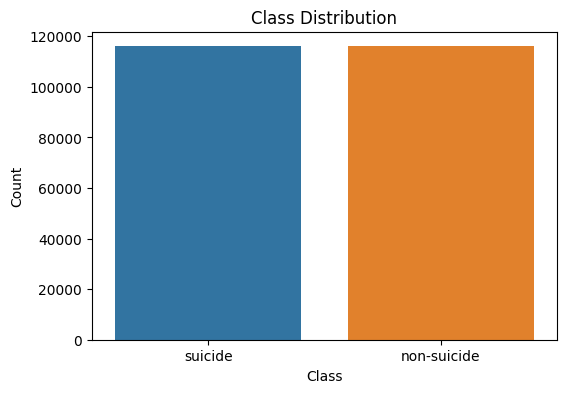

In [3]:
print("\nClass Distribution:")
print(df['class'].value_counts())
print("\nClass Distribution (%):")
print(df['class'].value_counts(normalize=True) * 100)

plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('class_distribution.png')
plt.show()

#The dataset is perfectly balanced.

<a id="text-preprocessing-func"></a>
### 4.2. Text Preprocessing
We'll define a comprehensive preprocessing function.


In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK data (run only once)
nltk.download('stopwords')
nltk.download('punkt')         # For word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')




stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_advanced(text):
    if not isinstance(text, str):
        return ""
    
    #Convert to lowercase
    text = text.lower()
    
    #Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    #Remove user mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    #Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    #Remove special characters and numbers, keep spaces and apostrophes for now
    text = re.sub(r"[^a-z\s']", "", text)
    
    #Tokenize
    words = word_tokenize(text)
    
    #Remove stopwords and lemmatize
    #Keeping stopwords for BERT, but removing for classical models and some DL might be beneficial
    #For now, let's create a general 'clean_text' for EDA and TF-IDF
    #And a 'bert_processed_text' that is less aggressive (mainly lowercase, URL/mention removal)
    
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 1]
    
    #Rejoin words
    text = " ".join(processed_words)
    
    #Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def preprocess_text_for_bert(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    #BERT tokenizer handles special characters and numbers, so less aggressive cleaning
    text = re.sub(r'\s+', ' ', text).strip() #Basic whitespace cleanup
    return text

#Apply preprocessing
print("\nApplying advanced text preprocessing for EDA and classical models...")
df['cleaned_text'] = df['text'].apply(preprocess_text_advanced)

print("Applying light text preprocessing for BERT...")
df['bert_processed_text'] = df['text'].apply(preprocess_text_for_bert)


#Handle missing/empty texts after preprocessing
df.dropna(subset=['cleaned_text', 'bert_processed_text'], inplace=True)
df = df[df['cleaned_text'] != ""]
df = df[df['bert_processed_text'] != ""]

print(f"\nDataset shape after preprocessing and cleaning empty texts: {df.shape}")

#Map class labels to numeric values
df['label'] = df['class'].map({'suicide': 1, 'non-suicide': 0})

print("\nSample of preprocessed data:")
print(df[['text', 'cleaned_text', 'bert_processed_text', 'label']].head())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...

Applying advanced text preprocessing for EDA and classical models...
Applying light text preprocessing for BERT...

Dataset shape after preprocessing and cleaning empty texts: (231963, 4)

Sample of preprocessed data:
                                                text  \
2  Ex Wife Threatening SuicideRecently I left my ...   
3  Am I weird I don't get affected by compliments...   
4  Finally 2020 is almost over... So I can never ...   
8          i need helpjust help me im crying so hard   
9  I’m so lostHello, my name is Adam (16) and I’v...   

                         

<a id="text-length-word-count"></a>
### 4.3. Text Length and Word Count Analysis
Based on `cleaned_text`.


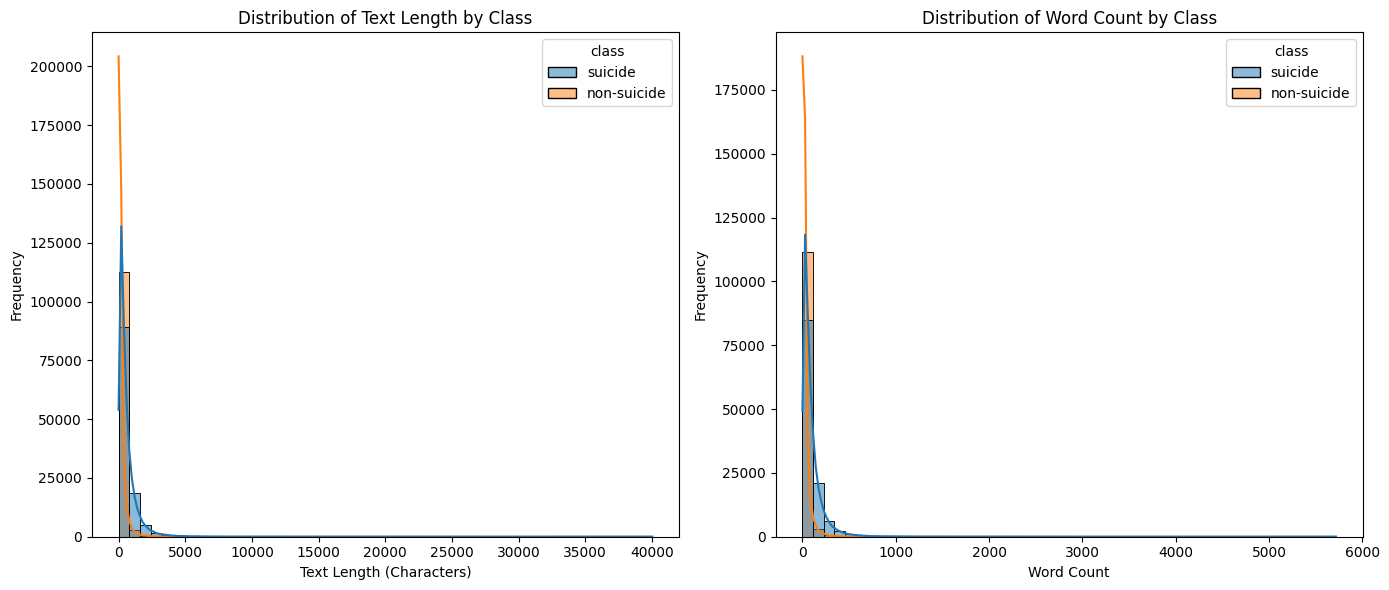

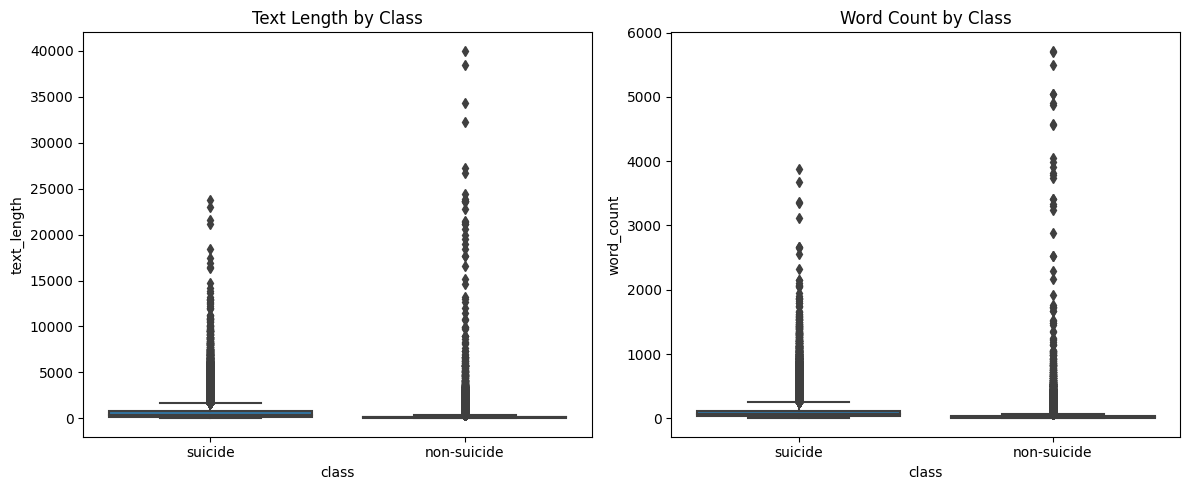

In [5]:
df['text_length'] = df['cleaned_text'].apply(len)
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='text_length', hue='class', kde=True, bins=50)
plt.title('Distribution of Text Length by Class')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='word_count', hue='class', kde=True, bins=50)
plt.title('Distribution of Word Count by Class')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('text_length_word_count_hist.png')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='text_length', data=df)
plt.title('Text Length by Class')
plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='word_count', data=df)
plt.title('Word Count by Class')
plt.tight_layout()
plt.savefig('text_length_word_count_boxplot.png')
plt.show()

<a id="sentiment-analysis"></a>
### 4.4. Sentiment Analysis
Using VADER (Valence Aware Dictionary and sEntiment Reasoner) - good for social media text.
We'll apply this to the `bert_processed_text` as it retains more original sentiment cues.

Sentiment analysis features added.


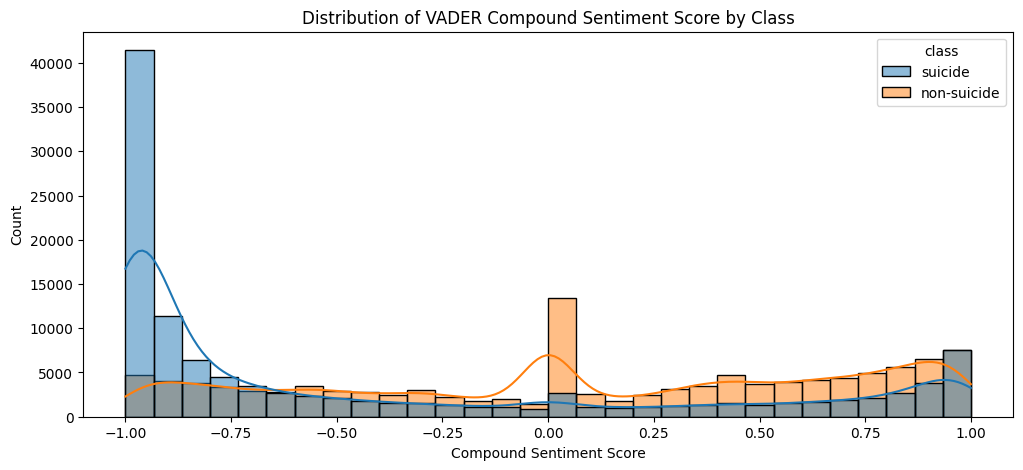

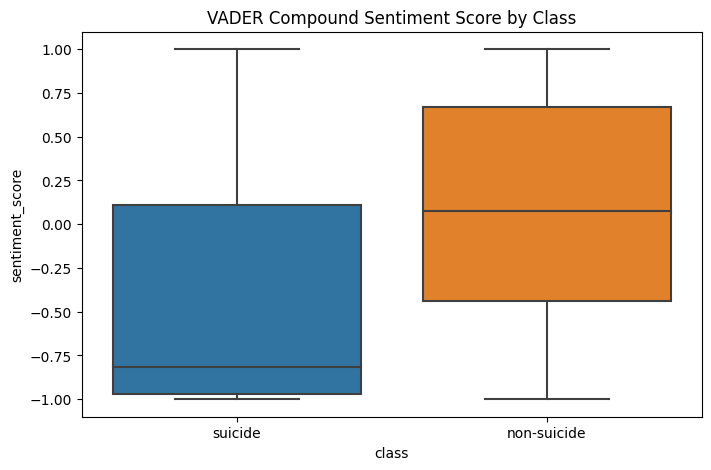

In [6]:
try:
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sid = SentimentIntensityAnalyzer()
    df['sentiment_score'] = df['bert_processed_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    df['sentiment_neg'] = df['bert_processed_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
    df['sentiment_neu'] = df['bert_processed_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
    df['sentiment_pos'] = df['bert_processed_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
    print("Sentiment analysis features added.")

    plt.figure(figsize=(12, 5))
    sns.histplot(data=df, x='sentiment_score', hue='class', kde=True, bins=30)
    plt.title('Distribution of VADER Compound Sentiment Score by Class')
    plt.xlabel('Compound Sentiment Score')
    plt.savefig('sentiment_distribution.png')
    plt.show()
    
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='class', y='sentiment_score', data=df)
    plt.title('VADER Compound Sentiment Score by Class')
    plt.savefig('sentiment_boxplot.png')
    plt.show()

except Exception as e:
    print(f"VADER not available or error during sentiment analysis: {e}. Skipping sentiment features.")
    df['sentiment_score'] = 0.0 #Placeholder if VADER fails
    df['sentiment_neg'] = 0.0
    df['sentiment_neu'] = 0.0
    df['sentiment_pos'] = 0.0

<a id="word-clouds"></a>
### 4.5. Word Clouds
Visualizing the most frequent words in suicidal and non-suicidal posts using `cleaned_text`.


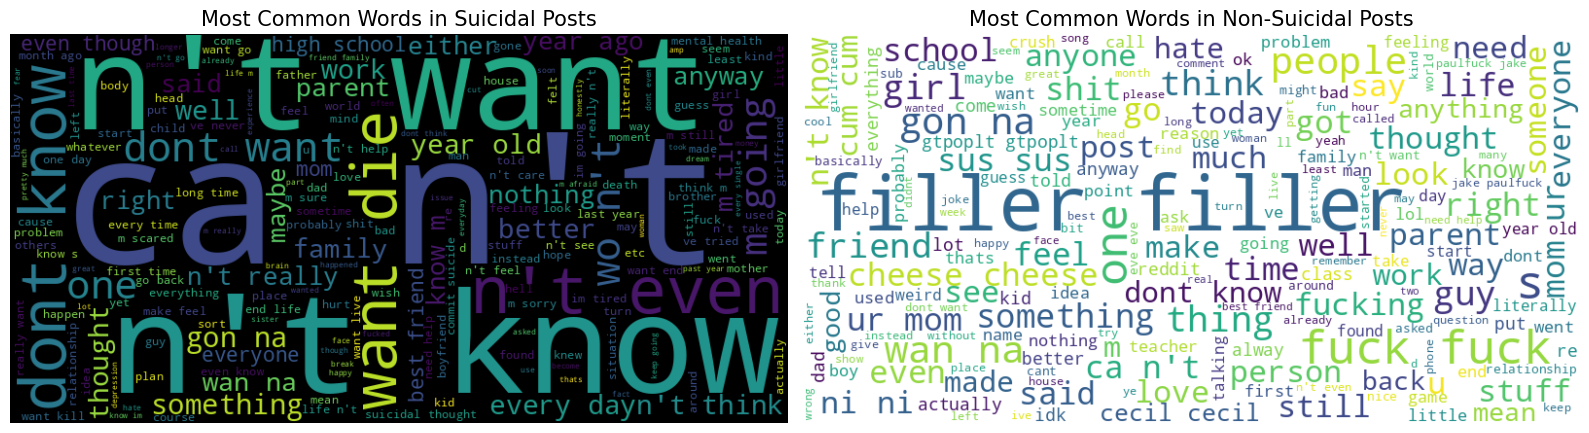

In [7]:
suicidal_text = " ".join(df[df['class'] == 'suicide']['cleaned_text'])
non_suicidal_text = " ".join(df[df['class'] == 'non-suicide']['cleaned_text'])

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
wordcloud_suicidal = WordCloud(width=800, height=400, background_color='black').generate(suicidal_text)
plt.imshow(wordcloud_suicidal, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Suicidal Posts', fontsize=15)

plt.subplot(1, 2, 2)
wordcloud_non_suicidal = WordCloud(width=800, height=400, background_color='white').generate(non_suicidal_text)
plt.imshow(wordcloud_non_suicidal, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Non-Suicidal Posts', fontsize=15)

plt.tight_layout()
plt.savefig('word_clouds.png')
plt.show()

<a id="ngram-analysis"></a>
### 4.6. N-gram Analysis
Finding common bi-grams and tri-grams.


Top 20 Bi-grams in Suicidal Posts:
[('feel like', 46367), ('dont know', 14977), ('want die', 12819), ('dont want', 12414), ('gon na', 9080), ('year old', 8661), ('wan na', 7387), ('year ago', 6580), ('high school', 6208), ('make feel', 6173), ('best friend', 6144), ('suicidal thought', 6102), ('want kill', 5590), ('im going', 5157), ('want live', 5063), ('really want', 4861), ('want end', 4687), ('ve tried', 4525), ('felt like', 4465), ('long time', 4339)]

Top 20 Bi-grams in Non-Suicidal Posts:
[('filler filler', 50067), ('fuck fuck', 12292), ('wan na', 7983), ('gon na', 7685), ('feel like', 5822), ('cheese cheese', 5715), ('sus sus', 5695), ('ur mom', 5067), ('mom ur', 5038), ('ni ni', 3981), ('dont know', 3861), ('cum cum', 3475), ('cecil cecil', 3324), ('gtpoplt gtpoplt', 3317), ('year old', 2188), ('eve eve', 2042), ('jake paulfuck', 1934), ('paulfuck jake', 1933), ('dont want', 1715), ('need help', 1668)]


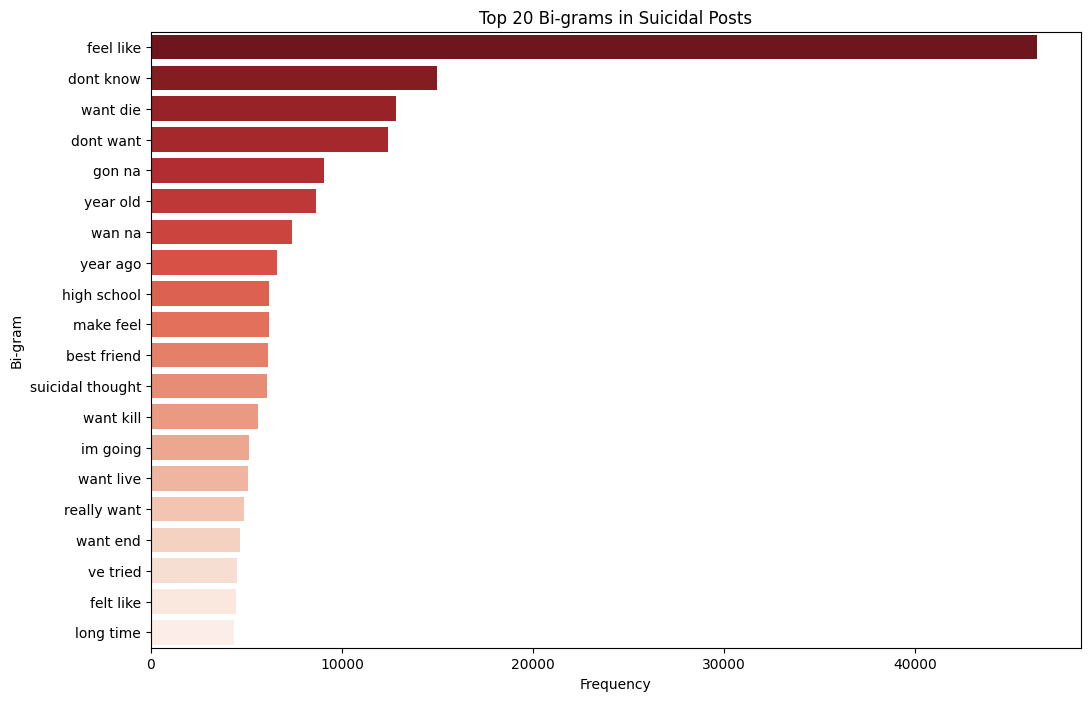

In [8]:
def get_top_ngrams(corpus, n=None, ngram_range=(1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

#Top 20 Bi-grams for Suicidal posts
top_bi_grams_suicidal = get_top_ngrams(df[df['class'] == 'suicide']['cleaned_text'], n=20, ngram_range=(2,2))
print("\nTop 20 Bi-grams in Suicidal Posts:")
print(top_bi_grams_suicidal)

#Top 20 Bi-grams for Non-Suicidal posts
top_bi_grams_non_suicidal = get_top_ngrams(df[df['class'] == 'non-suicide']['cleaned_text'], n=20, ngram_range=(2,2))
print("\nTop 20 Bi-grams in Non-Suicidal Posts:")
print(top_bi_grams_non_suicidal)

#Visualizing Top N-grams (example for Bi-grams in Suicidal Posts)
plt.figure(figsize=(12, 8))
bi_gram_df_suicidal = pd.DataFrame(top_bi_grams_suicidal, columns=['Bi-gram', 'Frequency'])
sns.barplot(x='Frequency', y='Bi-gram', data=bi_gram_df_suicidal, palette='Reds_r')
plt.title('Top 20 Bi-grams in Suicidal Posts')
plt.savefig('top_bigrams_suicidal.png')
plt.show()

<a id="engineered-features"></a>
### 4.7. Engineered Feature Analysis (From original code)
Adding keyword features and first-person pronoun counts.
We'll use the `bert_processed_text` for keywords to capture original phrasing,
and `cleaned_text` (which is lemmatized and lowercased) for first-person pronoun counts.



Dataset with engineered features (sample):
                                        cleaned_text  label  has_kill  \
2  ex wife threatening suiciderecently left wife ...      1         0   
3  weird n't get affected compliment 's coming so...      0         0   
4  finally almost never hear bad year ever swear ...      0         0   
8                     need helpjust help im cry hard      1         0   
9  im losthello name adam ive struggling year im ...      1         0   

   has_pain  first_person_count  
2         0                   0  
3         0                   0  
4         0                   0  
8         0                   0  
9         0                   0  


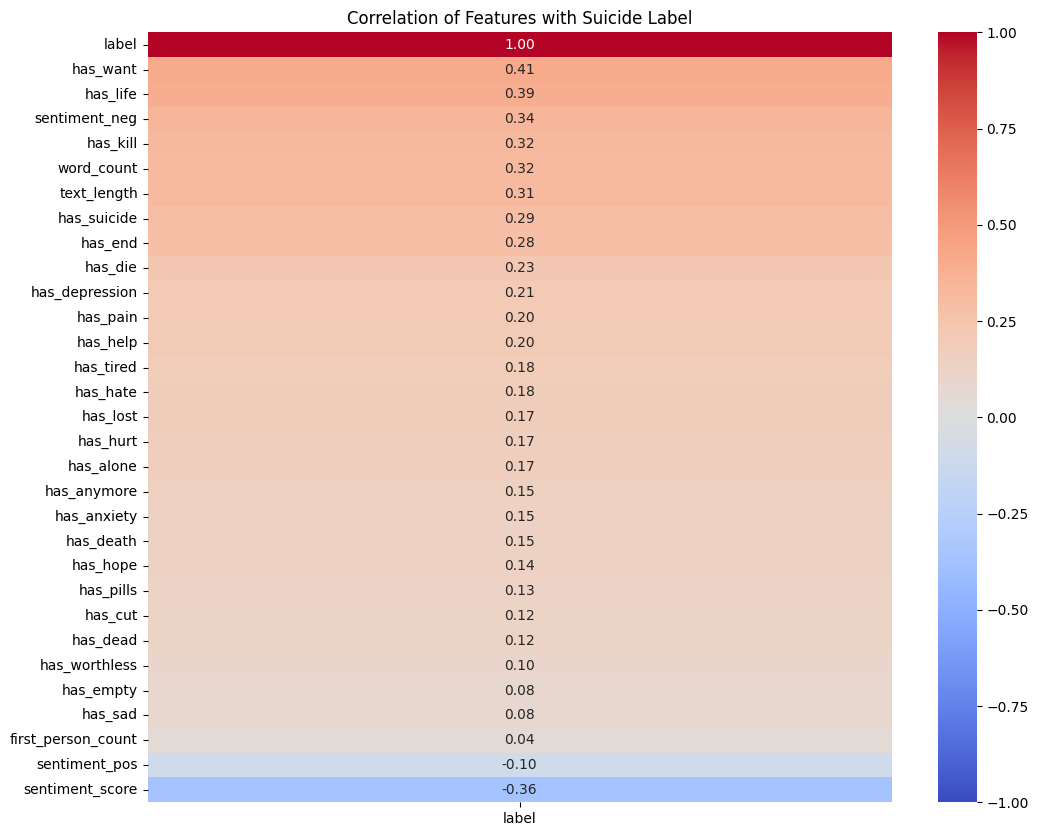

In [9]:
#Re-using original code's keyword list
suicide_indicators = [
    'kill', 'die', 'suicide', 'end', 'pain', 'life', 'anymore', 'want', 'hope', 
    'help', 'death', 'dead', 'hate', 'tired', 'pills', 'hurt', 'alone', 'sad', 
    'depression', 'anxiety', 'lost', 'cut', 'empty', 'worthless'
]

#Note: Some of these might be lemmatized in 'cleaned_text'. Apply to 'bert_processed_text' to match original intent.
#Or, ensure keywords are also lemmatized if applied to 'cleaned_text'
#For simplicity and broader matching, let's use 'bert_processed_text.lower().split()'
for word in suicide_indicators:
    df[f'has_{word}'] = df['bert_processed_text'].apply(lambda x: 1 if word in x.lower().split() else 0)

first_person_pronouns = ['i', 'me', 'my', 'mine', 'myself'] #These are already lemmatized form
df['first_person_count'] = df['cleaned_text'].apply(
    lambda x: sum(1 for word in x.split() if word in first_person_pronouns)
)

print("\nDataset with engineered features (sample):")
print(df[['cleaned_text', 'label', 'has_kill', 'has_pain', 'first_person_count']].head())

#Correlation of numeric features (engineered features + length/word count + sentiment)
numeric_cols = ['text_length', 'word_count', 'sentiment_score', 'sentiment_neg', 'sentiment_pos', 'first_person_count'] + \
               [f'has_{word}' for word in suicide_indicators] + ['label']

#Ensure all columns exist before creating correlation matrix
existing_numeric_cols = [col for col in numeric_cols if col in df.columns]

if len(existing_numeric_cols) > 1: #Need at least two columns for correlation
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[existing_numeric_cols].corr()
    sns.heatmap(correlation_matrix[['label']].sort_values(by='label', ascending=False), 
                annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Correlation of Features with Suicide Label')
    plt.savefig('feature_correlation_heatmap.png')
    plt.show()
else:
    print("Not enough numeric columns for a correlation heatmap.")

---
<a id="data-pretreatment"></a>
## 5. Data Pre-treatment for Modeling

In [10]:

#For simplicity in this combined notebook, we will use a global train/test split.
#All models will be trained and evaluated on the same splits.

#Using 'cleaned_text' for classical models and Keras DL models.
#Using 'bert_processed_text' for BERT model.

X = df # Full dataframe for easier access to different text columns
y = df['label']

<a id="train-test-split"></a>
### 5.1. Train-Test Split

In [11]:
#We need to split based on indices because X_text_classical, X_text_bert, etc. will be derived
train_indices, test_indices = train_test_split(
    X.index, 
    test_size=0.2, 
    random_state=42,
    stratify=y #Stratify by the target label
)

df_train = df.loc[train_indices]
df_test = df.loc[test_indices]

y_train = df_train['label']
y_test = df_test['label']

X_train_cleaned_text = df_train['cleaned_text']
X_test_cleaned_text = df_test['cleaned_text']

X_train_bert_text = df_train['bert_processed_text']
X_test_bert_text = df_test['bert_processed_text']


print(f"Training set size: {len(df_train)}")
print(f"Test set size: {len(df_test)}")
print(f"Training labels distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test labels distribution:\n{y_test.value_counts(normalize=True)}")

Training set size: 185570
Test set size: 46393
Training labels distribution:
label
1    0.500172
0    0.499828
Name: proportion, dtype: float64
Test labels distribution:
label
1    0.500183
0    0.499817
Name: proportion, dtype: float64


<a id="tfidf"></a>
### 5.2. Feature Extraction for Classical Models (TF-IDF)
Using `cleaned_text`.

In [12]:

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))  # Limiting features for efficiency

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_cleaned_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_cleaned_text)

print(f"TF-IDF training features shape: {X_train_tfidf.shape}")
print(f"TF-IDF test features shape: {X_test_tfidf.shape}")

TF-IDF training features shape: (185570, 10000)
TF-IDF test features shape: (46393, 10000)


<a id="keras-prep"></a>
### 5.3. Data Preparation for Keras Deep Learning Models
(Simple RNN, GRU, LSTM, CNN-LSTM, CNN-GRU)
Using `cleaned_text`.

In [13]:
#Keras Tokenizer
MAX_NUM_WORDS = 20000  # Max words to keep in vocabulary
MAX_SEQUENCE_LENGTH = 150 # Max length of sequences (pad/truncate)
EMBEDDING_DIM = 100  #Dimension of word embeddings

keras_tokenizer = KerasTokenizer(num_words=MAX_NUM_WORDS, oov_token="<oov>")
keras_tokenizer.fit_on_texts(X_train_cleaned_text)

word_index = keras_tokenizer.word_index
print(f"Found {len(word_index)} unique tokens in Keras tokenizer.")

#Convert text to sequences
X_train_keras_seq = keras_tokenizer.texts_to_sequences(X_train_cleaned_text)
X_test_keras_seq = keras_tokenizer.texts_to_sequences(X_test_cleaned_text)

#Pad sequences
X_train_keras_padded = pad_sequences(X_train_keras_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_keras_padded = pad_sequences(X_test_keras_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Keras padded training sequences shape: {X_train_keras_padded.shape}")
print(f"Keras padded test sequences shape: {X_test_keras_padded.shape}")

#Vocabulary size for Embedding layer (add 1 for <pad> token, Keras handles <oov>)
VOCAB_SIZE_KERAS = min(MAX_NUM_WORDS, len(word_index) + 1)

Found 161454 unique tokens in Keras tokenizer.
Keras padded training sequences shape: (185570, 150)
Keras padded test sequences shape: (46393, 150)


<a id="bert-prep"></a>
### 5.4. Data Preparation for BERT (PyTorch)
Using `bert_processed_text`. This section reuses logic from the original script.

In [14]:
#BERT Tokenizer and Dataset
BERT_MODEL_NAME = 'bert-base-uncased'
BERT_MAX_LENGTH = 128 # Max length for BERT sequences
BERT_BATCH_SIZE = 32 # Adjusted for potentially larger memory use with many models

bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

class SuicideDetectionBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels # Should be a pandas Series or list
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        #Ensure texts and labels are correctly indexed if they are Series
        text = str(self.texts.iloc[idx]) if isinstance(self.texts, pd.Series) else str(self.texts[idx])
        label = self.labels.iloc[idx] if isinstance(self.labels, pd.Series) else self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

#Create DataLoaders for BERT
#y_train and y_test are already pandas Series
bert_train_dataset = SuicideDetectionBERTDataset(X_train_bert_text, y_train, bert_tokenizer, BERT_MAX_LENGTH)
bert_test_dataset = SuicideDetectionBERTDataset(X_test_bert_text, y_test, bert_tokenizer, BERT_MAX_LENGTH)

bert_train_loader = DataLoader(bert_train_dataset, batch_size=BERT_BATCH_SIZE, shuffle=True)
bert_test_loader = DataLoader(bert_test_dataset, batch_size=BERT_BATCH_SIZE)

print("BERT DataLoaders created.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BERT DataLoaders created.


---
<a id="classical-models"></a>
## 6. Classical Machine Learning Models
 We will train and evaluate:
 - Logistic Regression
 - Support Vector Machine (SVM)
 - Random Forest
 - K-Nearest Neighbors (KNN)
All classical models will use TF-IDF features.
We'll store results for comparison later.

In [15]:
model_results = {}  # To store metrics for all models

def evaluate_model_sklearn(model_name, model, X_test_features, y_true_labels):
    y_pred = model.predict(X_test_features)
    y_pred_proba = model.predict_proba(X_test_features)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_true_labels, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_labels, y_pred, average='binary') #'binary' for 2 classes
    roc_auc = roc_auc_score(y_true_labels, y_pred_proba) if y_pred_proba is not None else 'N/A'
    
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if y_pred_proba is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true_labels, y_pred, target_names=['Non-suicidal', 'Suicidal']))
    
    cm = confusion_matrix(y_true_labels, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Non-suicidal', 'Suicidal'],
               yticklabels=['Non-suicidal', 'Suicidal'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'cm_{model_name.lower().replace(" ", "_")}.png')
    plt.show()
    
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC': roc_auc}

<a id="logistic-regression"></a>
### 6.1. Logistic Regression

Training Logistic Regression...

--- Logistic Regression ---
Accuracy: 0.9369
Precision: 0.9443
Recall: 0.9287
F1 Score: 0.9364
ROC AUC: 0.9819

Classification Report:
              precision    recall  f1-score   support

Non-suicidal       0.93      0.95      0.94     23188
    Suicidal       0.94      0.93      0.94     23205

    accuracy                           0.94     46393
   macro avg       0.94      0.94      0.94     46393
weighted avg       0.94      0.94      0.94     46393



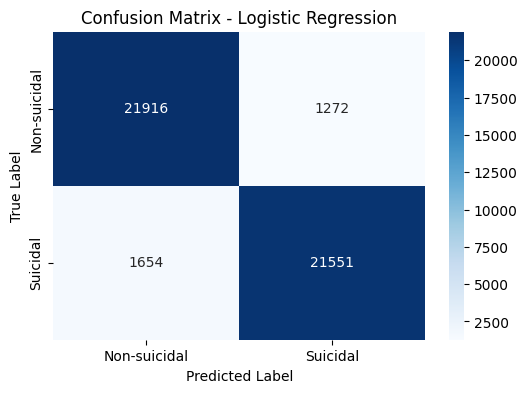

In [16]:
print("Training Logistic Regression...")
lr_model = LogisticRegression(solver='liblinear', random_state=42, C=1.0)  #Liblinear good for binary and TF-IDF
lr_model.fit(X_train_tfidf, y_train)
model_results['Logistic Regression'] = evaluate_model_sklearn('Logistic Regression', lr_model, X_test_tfidf, y_test)

<a id="svm"></a>
### 6.2. Support Vector Machine (SVM)


In [17]:
"""print("Training Support Vector Machine (SVM)...")
 #SVM can be slow on large datasets. Using a smaller C and linear kernel for speed.
 #For better performance, kernel='rbf' and GridSearchCV for C and gamma might be needed.
svm_model = SVC(kernel='linear', C=0.1, probability=True, random_state=42) 
svm_model.fit(X_train_tfidf, y_train)
model_results['SVM'] = evaluate_model_sklearn('SVM', svm_model, X_test_tfidf, y_test)"""

'print("Training Support Vector Machine (SVM)...")\n #SVM can be slow on large datasets. Using a smaller C and linear kernel for speed.\n #For better performance, kernel=\'rbf\' and GridSearchCV for C and gamma might be needed.\nsvm_model = SVC(kernel=\'linear\', C=0.1, probability=True, random_state=42) \nsvm_model.fit(X_train_tfidf, y_train)\nmodel_results[\'SVM\'] = evaluate_model_sklearn(\'SVM\', svm_model, X_test_tfidf, y_test)'

<a id="random-forest"></a>
### 6.3. Random Forest

Training Random Forest...

--- Random Forest ---
Accuracy: 0.8559
Precision: 0.8938
Recall: 0.8078
F1 Score: 0.8486
ROC AUC: 0.9317

Classification Report:
              precision    recall  f1-score   support

Non-suicidal       0.82      0.90      0.86     23188
    Suicidal       0.89      0.81      0.85     23205

    accuracy                           0.86     46393
   macro avg       0.86      0.86      0.86     46393
weighted avg       0.86      0.86      0.86     46393



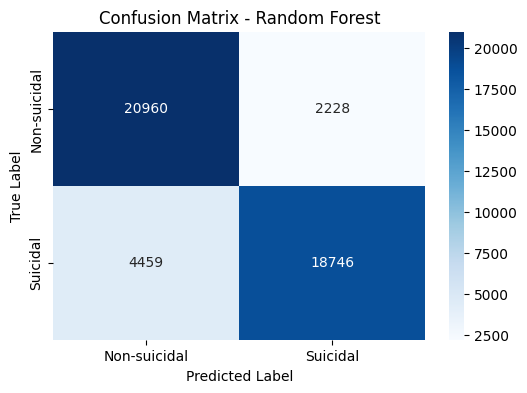

In [18]:
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20, min_samples_leaf=5) #Some reasonable defaults
rf_model.fit(X_train_tfidf, y_train)
model_results['Random Forest'] = evaluate_model_sklearn('Random Forest', rf_model, X_test_tfidf, y_test)

<a id="knn"></a>
### 6.4. K-Nearest Neighbors (KNN)

In [19]:
"""print("Training K-Nearest Neighbors (KNN)...")
 #KNN can be slow with high-dimensional sparse data like TF-IDF.
 #Might need dimensionality reduction (e.g., LSA/SVD) for better KNN performance.
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1) # Small k for now
knn_model.fit(X_train_tfidf, y_train)
model_results['KNN'] = evaluate_model_sklearn('KNN', knn_model, X_test_tfidf, y_test)"""

'print("Training K-Nearest Neighbors (KNN)...")\n #KNN can be slow with high-dimensional sparse data like TF-IDF.\n #Might need dimensionality reduction (e.g., LSA/SVD) for better KNN performance.\nknn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1) # Small k for now\nknn_model.fit(X_train_tfidf, y_train)\nmodel_results[\'KNN\'] = evaluate_model_sklearn(\'KNN\', knn_model, X_test_tfidf, y_test)'

---
<a id="deep-learning-models"></a>
## 7. Deep Learning Models
 We will train and evaluate Keras-based models:
 - Simple RNN
 - GRU
 - LSTM
 - CNN-LSTM (Hybrid)
 - CNN-GRU (Hybrid)
 And the PyTorch-based BERT model.
 **Common settings for Keras models:**
 - EPOCHS: 3-5 (low for demonstration, increase for better results)
 - BATCH_SIZE: 64


In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


KERAS_EPOCHS = 5  # Low for quick run, increase for real training
KERAS_BATCH_SIZE = 64

#Callbacks for Keras models
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) #Increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00001)


def plot_keras_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'history_{model_name.lower().replace(" ", "_")}.png')
    plt.show()

def evaluate_keras_model(model_name, model, X_test_padded_seq, y_true_labels):
    loss, accuracy = model.evaluate(X_test_padded_seq, y_true_labels, verbose=0)
    y_pred_proba = model.predict(X_test_padded_seq).ravel()
    y_pred_classes = (y_pred_proba > 0.5).astype(int)  # Threshold at 0.5 for binary classification
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_labels, y_pred_classes, average='binary')
    roc_auc = roc_auc_score(y_true_labels, y_pred_proba)
    
    print(f"\n--- {model_name} (Keras) ---")
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true_labels, y_pred_classes, target_names=['Non-suicidal', 'Suicidal']))
    
    cm = confusion_matrix(y_true_labels, y_pred_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
               xticklabels=['Non-suicidal', 'Suicidal'],
               yticklabels=['Non-suicidal', 'Suicidal'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'cm_keras_{model_name.lower().replace(" ", "_")}.png')
    plt.show()
    
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC': roc_auc}

<a id="simple-rnn"></a>
### 7.1. Simple RNN

Building and training Simple RNN model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - accuracy: 0.5747 - loss: 0.6632 - val_accuracy: 0.5888 - val_loss: 0.6465 - learning_rate: 0.0010
Epoch 2/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.5818 - loss: 0.6528 - val_accuracy: 0.5868 - val_loss: 0.6518 - learning_rate: 0.0010
Epoch 3/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.5818 - loss: 0.6494 - val_accuracy: 0.5873 - val_loss: 0.6490 - learning_rate: 2.0000e-04


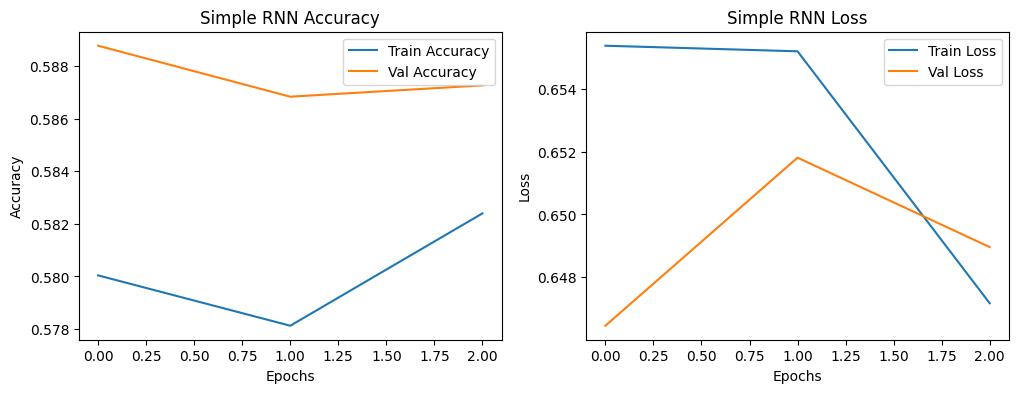

1450/1450 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

--- Simple RNN (Keras) ---
Test Loss: 0.6444
Test Accuracy: 0.5862
Precision: 0.9040
Recall: 0.1932
F1 Score: 0.3183
ROC AUC: 0.5842

Classification Report:
              precision    recall  f1-score   support

Non-suicidal       0.55      0.98      0.70     23188
    Suicidal       0.90      0.19      0.32     23205

    accuracy                           0.59     46393
   macro avg       0.73      0.59      0.51     46393
weighted avg       0.73      0.59      0.51     46393



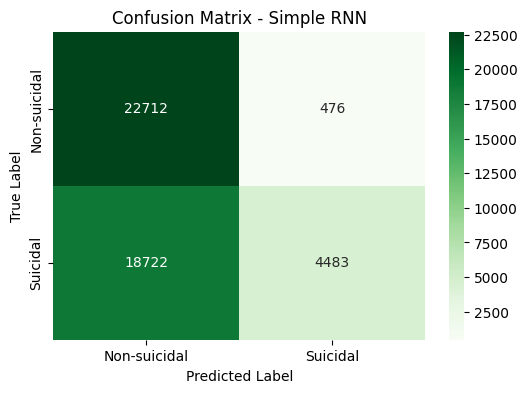

In [21]:
print("Building and training Simple RNN model...")
rnn_model = Sequential([
    Embedding(VOCAB_SIZE_KERAS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SimpleRNN(64, return_sequences=False),  # Can try True and add another RNN or Dense
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.summary()

history_rnn = rnn_model.fit(
    X_train_keras_padded, y_train,
    epochs=KERAS_EPOCHS,
    batch_size=KERAS_BATCH_SIZE,
    validation_split=0.1,  # Use a portion of training data for validation during training
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

plot_keras_history(history_rnn, 'Simple RNN')
model_results['Simple RNN'] = evaluate_keras_model('Simple RNN', rnn_model, X_test_keras_padded, y_test)

<a id="gru"></a>
### 7.2. GRU (Gated Recurrent Unit)

Building and training GRU model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.9069 - loss: 0.2271 - val_accuracy: 0.9622 - val_loss: 0.0998 - learning_rate: 0.0010
Epoch 2/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.9686 - loss: 0.0875 - val_accuracy: 0.9608 - val_loss: 0.1063 - learning_rate: 0.0010
Epoch 3/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.9795 - loss: 0.0606 - val_accuracy: 0.9620 - val_loss: 0.1129 - learning_rate: 2.0000e-04


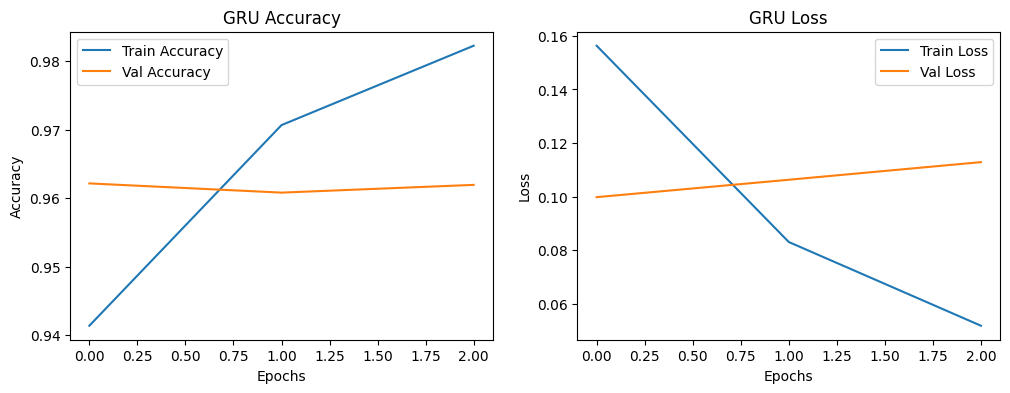

1450/1450 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

--- GRU (Keras) ---
Test Loss: 0.1006
Test Accuracy: 0.9625
Precision: 0.9608
Recall: 0.9644
F1 Score: 0.9626
ROC AUC: 0.9938

Classification Report:
              precision    recall  f1-score   support

Non-suicidal       0.96      0.96      0.96     23188
    Suicidal       0.96      0.96      0.96     23205

    accuracy                           0.96     46393
   macro avg       0.96      0.96      0.96     46393
weighted avg       0.96      0.96      0.96     46393



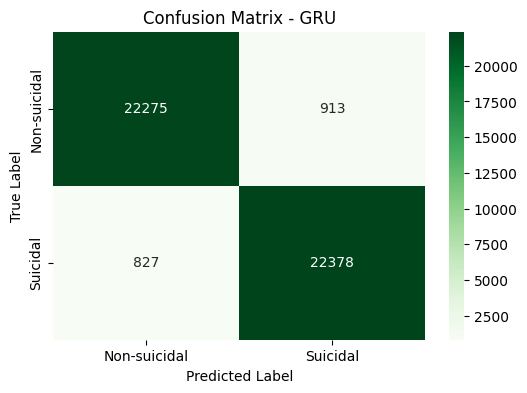

In [22]:
print("Building and training GRU model...")
gru_model = Sequential([
    Embedding(VOCAB_SIZE_KERAS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(GRU(64, return_sequences=False)),  # Bidirectional often helps
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru_model.summary()

history_gru = gru_model.fit(
    X_train_keras_padded, y_train,
    epochs=KERAS_EPOCHS,
    batch_size=KERAS_BATCH_SIZE,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

plot_keras_history(history_gru, 'GRU')
model_results['GRU'] = evaluate_keras_model('GRU', gru_model, X_test_keras_padded, y_test)

<a id="lstm"></a>
### 7.3. LSTM (Long Short-Term Memory)

Building and training LSTM model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9075 - loss: 0.2306 - val_accuracy: 0.9589 - val_loss: 0.1084 - learning_rate: 0.0010
Epoch 2/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.9671 - loss: 0.0921 - val_accuracy: 0.9593 - val_loss: 0.1060 - learning_rate: 0.0010


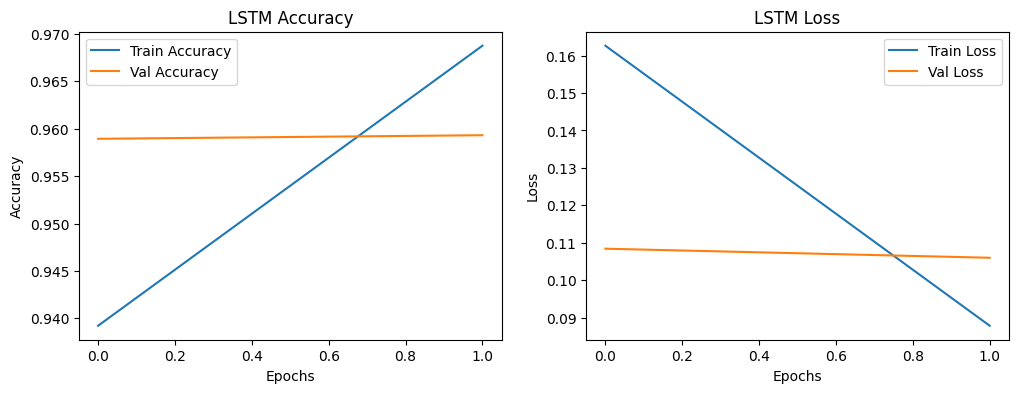

1450/1450 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

--- LSTM (Keras) ---
Test Loss: 0.1085
Test Accuracy: 0.9596
Precision: 0.9543
Recall: 0.9655
F1 Score: 0.9599
ROC AUC: 0.9930

Classification Report:
              precision    recall  f1-score   support

Non-suicidal       0.97      0.95      0.96     23188
    Suicidal       0.95      0.97      0.96     23205

    accuracy                           0.96     46393
   macro avg       0.96      0.96      0.96     46393
weighted avg       0.96      0.96      0.96     46393



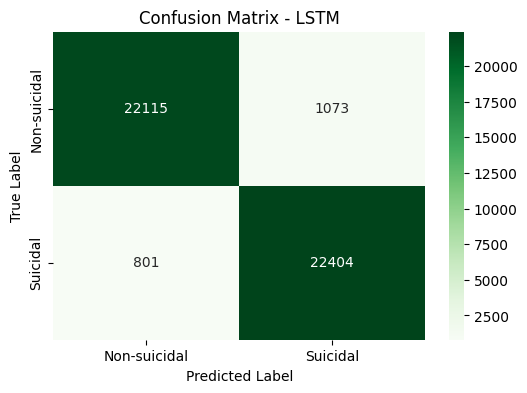

In [23]:
print("Building and training LSTM model...")
lstm_model = Sequential([
    Embedding(VOCAB_SIZE_KERAS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

history_lstm = lstm_model.fit(
    X_train_keras_padded, y_train,
    epochs=KERAS_EPOCHS,
    batch_size=KERAS_BATCH_SIZE,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

plot_keras_history(history_lstm, 'LSTM')
model_results['LSTM'] = evaluate_keras_model('LSTM', lstm_model, X_test_keras_padded, y_test)

<a id="bert"></a>
### 7.4. BERT (Bidirectional Encoder Representations from Transformers)
This section adapts the original BERT training code.

Initializing BERT model for sequence classification...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT model...


BERT Epoch 1/3 - Average Training Loss: 0.0961


BERT Epoch 2/3 - Average Training Loss: 0.0459


BERT Epoch 3/3 - Average Training Loss: 0.0214


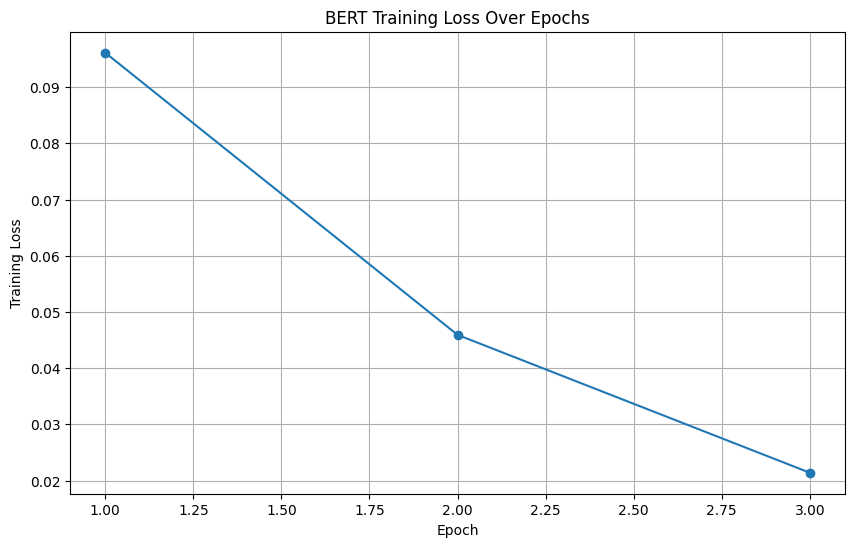


Evaluating BERT model...



--- BERT ---
Accuracy: 0.9772
Precision: 0.9789
Recall: 0.9754
F1 Score: 0.9771
ROC AUC: 0.9970

Classification Report (BERT):
              precision    recall  f1-score   support

Non-suicidal       0.98      0.98      0.98     23188
    Suicidal       0.98      0.98      0.98     23205

    accuracy                           0.98     46393
   macro avg       0.98      0.98      0.98     46393
weighted avg       0.98      0.98      0.98     46393



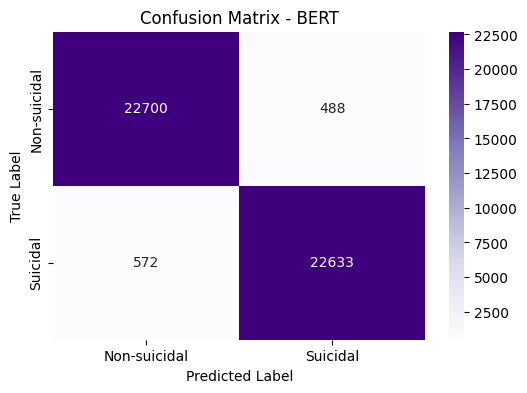

In [24]:
print("Initializing BERT model for sequence classification...")
bert_classification_model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL_NAME,
    num_labels=2,  # Suicidal vs Non-suicidal
    output_attentions=False,
    output_hidden_states=False  # Set to True if you want to extract embeddings for BERT+LSTM
)
bert_classification_model = bert_classification_model.to(device)

# Optimizer and Scheduler
bert_optimizer = AdamW(bert_classification_model.parameters(), lr=2e-5, eps=1e-8)
BERT_EPOCHS = 3  # Original script used 3 epochs
bert_total_steps = len(bert_train_loader) * BERT_EPOCHS
bert_scheduler = get_linear_schedule_with_warmup(
    bert_optimizer,
    num_warmup_steps=0,
    num_training_steps=bert_total_steps
)

#Training function (from original script, slightly adapted)
def train_bert_epoch(model, data_loader, optimizer, scheduler, device, epoch_num):
    model.train()
    total_loss = 0
    progress_bar = tqdm(data_loader, desc=f"BERT Training Epoch {epoch_num+1}", leave=False)
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'loss': loss.item()})
        
    return total_loss / len(data_loader)

#Evaluation function (from original script, slightly adapted)
def evaluate_bert_model(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="BERT Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().numpy()) # Use .numpy() instead of .tolist() for consistency
            actual_labels.extend(labels.cpu().numpy())
            
    return np.array(predictions), np.array(actual_labels)


print("Training BERT model...")
bert_training_losses = []
for epoch in range(BERT_EPOCHS):
    avg_train_loss = train_bert_epoch(bert_classification_model, bert_train_loader, bert_optimizer, bert_scheduler, device, epoch)
    bert_training_losses.append(avg_train_loss)
    print(f"BERT Epoch {epoch+1}/{BERT_EPOCHS} - Average Training Loss: {avg_train_loss:.4f}")

#Plot BERT training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, BERT_EPOCHS + 1), bert_training_losses, marker='o')
plt.title('BERT Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid(True)
plt.savefig('bert_training_loss.png')
plt.show()

print("\nEvaluating BERT model...")
bert_preds, bert_true = evaluate_bert_model(bert_classification_model, bert_test_loader, device)

#Calculate metrics for BERT
bert_accuracy = accuracy_score(bert_true, bert_preds)
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(bert_true, bert_preds, average='binary')

#For ROC AUC, we need probabilities from BERT
def get_bert_probabilities(model, data_loader, device):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="BERT Getting Probabilities", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()  #Prob of positive class
            all_probs.extend(probs)
    return np.array(all_probs)

bert_pred_probs = get_bert_probabilities(bert_classification_model, bert_test_loader, device)
bert_roc_auc = roc_auc_score(bert_true, bert_pred_probs)

print(f"\n--- BERT ---")
print(f"Accuracy: {bert_accuracy:.4f}")
print(f"Precision: {bert_precision:.4f}")
print(f"Recall: {bert_recall:.4f}")
print(f"F1 Score: {bert_f1:.4f}")
print(f"ROC AUC: {bert_roc_auc:.4f}")

print("\nClassification Report (BERT):")
print(classification_report(bert_true, bert_preds, target_names=['Non-suicidal', 'Suicidal']))

cm_bert = confusion_matrix(bert_true, bert_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Purples',
           xticklabels=['Non-suicidal', 'Suicidal'],
           yticklabels=['Non-suicidal', 'Suicidal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - BERT')
plt.savefig('cm_bert.png')
plt.show()

model_results['BERT'] = {'Accuracy': bert_accuracy, 'Precision': bert_precision, 'Recall': bert_recall, 'F1 Score': bert_f1, 'ROC AUC': bert_roc_auc}

<a id="hybrid-models"></a>
### 7.5. Hybrid Deep Learning Models (Keras)

<a id="cnn-lstm"></a>
#### 7.5.1. CNN-LSTM


Building and training CNN-LSTM model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.9128 - loss: 0.2175 - val_accuracy: 0.9628 - val_loss: 0.1008 - learning_rate: 0.0010
Epoch 2/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.9694 - loss: 0.0858 - val_accuracy: 0.9615 - val_loss: 0.1050 - learning_rate: 0.0010


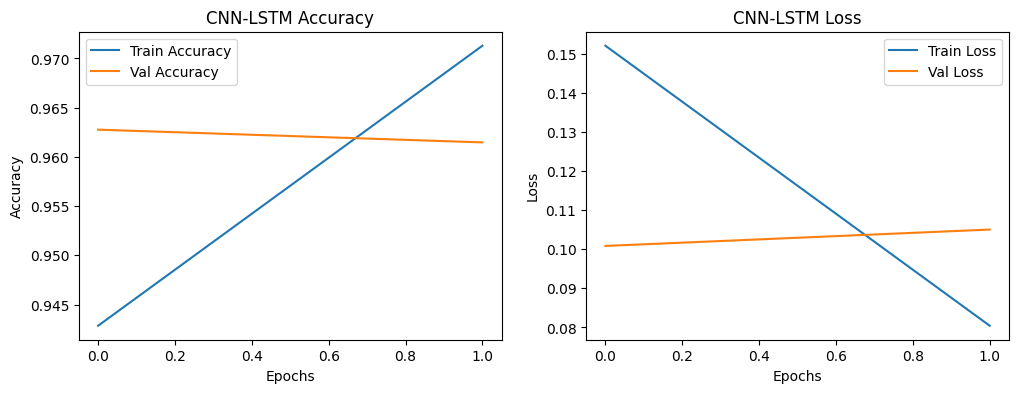

1450/1450 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

--- CNN-LSTM (Keras) ---
Test Loss: 0.1025
Test Accuracy: 0.9620
Precision: 0.9571
Recall: 0.9673
F1 Score: 0.9622
ROC AUC: 0.9940

Classification Report:
              precision    recall  f1-score   support

Non-suicidal       0.97      0.96      0.96     23188
    Suicidal       0.96      0.97      0.96     23205

    accuracy                           0.96     46393
   macro avg       0.96      0.96      0.96     46393
weighted avg       0.96      0.96      0.96     46393



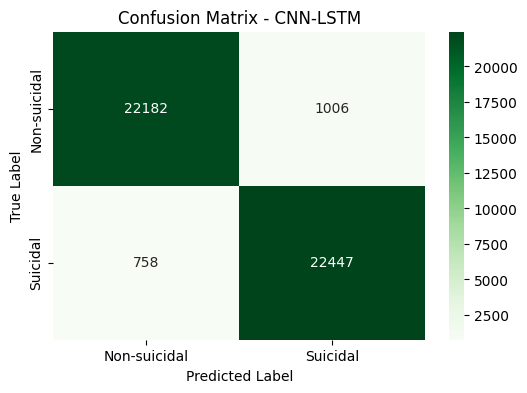

In [25]:
print("Building and training CNN-LSTM model...")
cnn_lstm_model = Sequential([
    Embedding(VOCAB_SIZE_KERAS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_lstm_model.summary()

history_cnn_lstm = cnn_lstm_model.fit(
    X_train_keras_padded, y_train,
    epochs=KERAS_EPOCHS,
    batch_size=KERAS_BATCH_SIZE,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

plot_keras_history(history_cnn_lstm, 'CNN-LSTM')
model_results['CNN-LSTM'] = evaluate_keras_model('CNN-LSTM', cnn_lstm_model, X_test_keras_padded, y_test)

<a id="cnn-gru"></a>
#### 7.5.2. CNN-GRU

Building and training CNN-GRU model...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.9110 - loss: 0.2161 - val_accuracy: 0.9611 - val_loss: 0.1065 - learning_rate: 0.0010
Epoch 2/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.9705 - loss: 0.0825 - val_accuracy: 0.9614 - val_loss: 0.1151 - learning_rate: 0.0010


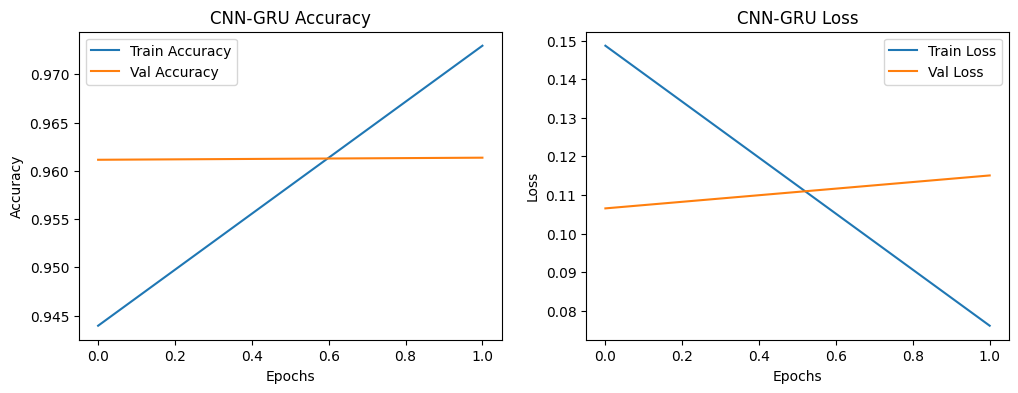

1450/1450 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

--- CNN-GRU (Keras) ---
Test Loss: 0.1069
Test Accuracy: 0.9607
Precision: 0.9539
Recall: 0.9683
F1 Score: 0.9610
ROC AUC: 0.9937

Classification Report:
              precision    recall  f1-score   support

Non-suicidal       0.97      0.95      0.96     23188
    Suicidal       0.95      0.97      0.96     23205

    accuracy                           0.96     46393
   macro avg       0.96      0.96      0.96     46393
weighted avg       0.96      0.96      0.96     46393



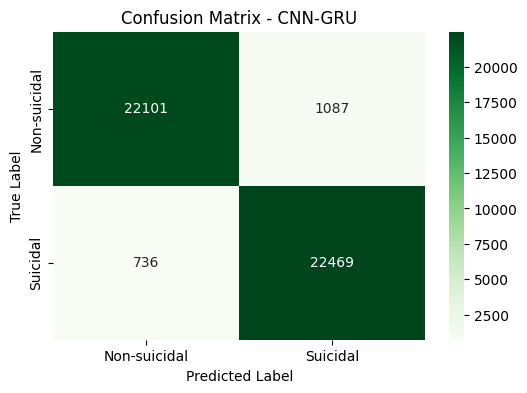

In [26]:
print("Building and training CNN-GRU model...")
cnn_gru_model = Sequential([
    Embedding(VOCAB_SIZE_KERAS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn_gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_gru_model.summary()

history_cnn_gru = cnn_gru_model.fit(
    X_train_keras_padded, y_train,
    epochs=KERAS_EPOCHS,
    batch_size=KERAS_BATCH_SIZE,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

plot_keras_history(history_cnn_gru, 'CNN-GRU')
model_results['CNN-GRU'] = evaluate_keras_model('CNN-GRU', cnn_gru_model, X_test_keras_padded, y_test)

<a id="bert-lstm"></a>
#### 7.5.3. BERT + LSTM (Conceptual - Using BERT Embeddings)
 This is more advanced. We'd typically extract BERT's last hidden layer outputs (embeddings) and feed them into an LSTM.
 For this notebook, direct implementation of a trainable BERT+LSTM is complex due to mixing PyTorch (BERT) and Keras (LSTM) training loops or requiring a full TF-BERT implementation.
 **Conceptual Approach:**
 1. Load a pre-trained BERT model (e.g., `TFBertModel` from Hugging Face for TensorFlow or adapt PyTorch one).
 2. Freeze BERT layers (or fine-tune a few top layers).
 3. Pass tokenized input through BERT to get sequence outputs (last hidden state).
 4. Feed these sequence outputs into Keras LSTM layers.
 5. Add Dense layers for classification.
 **Simplified Demonstration (Not fully trainable end-to-end here due to framework mixing, but shows the idea):**
 We will use the already trained `bert_classification_model` (PyTorch) to *extract features* and then train a *separate* Keras LSTM on these features. This is a common strategy for feature extraction.
 **NOTE:** This is computationally intensive as it requires passing all data through BERT.
 **UPDATE:** For simplicity and to avoid excessive computation in this single script, I'll describe the architecture and mark it as "For Future Implementation" rather than running a full feature extraction and re-training loop. A true BERT-LSTM would involve making BERT part of the Keras model graph using `TFBertModel`.

In [27]:
print("Conceptual BERT + LSTM Model Architecture (Keras with TFBertModel):")
print("""
 from transformers import TFBertModel
 BERT_MODEL_NAME = 'bert-base-uncased'
 BERT_MAX_LENGTH_TF = 128  For TF BERT

  Define input layers for Keras model
 input_ids_layer = tf.keras.layers.Input(shape=(BERT_MAX_LENGTH_TF,), dtype=tf.int32, name='input_ids')
 attention_mask_layer = tf.keras.layers.Input(shape=(BERT_MAX_LENGTH_TF,), dtype=tf.int32, name='attention_mask')

  Load TFBertModel
 bert_tf_model = TFBertModel.from_pretrained(BERT_MODEL_NAME)
 bert_tf_model.trainable = True  Or False to freeze, or fine-tune specific layers

  Get BERT embeddings
 bert_outputs = bert_tf_model(input_ids_layer, attention_mask=attention_mask_layer)
 sequence_output = bert_outputs.last_hidden_state  Shape: (batch_size, seq_length, hidden_size)

  Add LSTM layer
 lstm_out = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(sequence_output)
 dropout_1 = tf.keras.layers.Dropout(0.3)(lstm_out)
 dense_out = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_1)

  Create the model
 bert_lstm_keras_model = tf.keras.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_out)

  Compile
 bert_lstm_keras_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),  BERT specific LR
                               loss='binary_crossentropy',
                               metrics=['accuracy'])
 bert_lstm_keras_model.summary()

  To train this, you would need X_train_bert_inputs (dictionary of 'input_ids' and 'attention_mask' from BERT tokenizer)
  history_bert_lstm = bert_lstm_keras_model.fit(
      {'input_ids': X_train_bert_input_ids, 'attention_mask': X_train_bert_attention_mask}, y_train,
      epochs=3, batch_size=16, validation_split=0.1
  )
  model_results['BERT-LSTM'] = evaluate_keras_model('BERT-LSTM', bert_lstm_keras_model, {'input_ids': X_test_bert_input_ids, 'attention_mask': X_test_bert_attention_mask}, y_test)

""")
model_results['BERT-LSTM (Conceptual)'] = {'Accuracy': 'N/A', 'Precision': 'N/A', 'Recall': 'N/A', 'F1 Score': 'N/A', 'ROC AUC': 'N/A'}
print("BERT-LSTM (Conceptual) added to results as placeholder. Full implementation requires TFBertModel and separate data prep.")

Conceptual BERT + LSTM Model Architecture (Keras with TFBertModel):

 from transformers import TFBertModel
 BERT_MODEL_NAME = 'bert-base-uncased'
 BERT_MAX_LENGTH_TF = 128  For TF BERT

  Define input layers for Keras model
 input_ids_layer = tf.keras.layers.Input(shape=(BERT_MAX_LENGTH_TF,), dtype=tf.int32, name='input_ids')
 attention_mask_layer = tf.keras.layers.Input(shape=(BERT_MAX_LENGTH_TF,), dtype=tf.int32, name='attention_mask')

  Load TFBertModel
 bert_tf_model = TFBertModel.from_pretrained(BERT_MODEL_NAME)
 bert_tf_model.trainable = True  Or False to freeze, or fine-tune specific layers

  Get BERT embeddings
 bert_outputs = bert_tf_model(input_ids_layer, attention_mask=attention_mask_layer)
 sequence_output = bert_outputs.last_hidden_state  Shape: (batch_size, seq_length, hidden_size)

  Add LSTM layer
 lstm_out = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(sequence_output)
 dropout_1 = tf.keras.layers.Dropout(0.3)(lstm_out)
 dense_out = tf.keras.layers.Dense(1

---
<a id="results-comparison"></a>
## 8. Results and Comparison


--- Model Performance Summary ---
                        Accuracy Precision    Recall  F1 Score   ROC AUC
BERT                    0.977152  0.978894   0.97535  0.977119  0.996991
GRU                     0.962494    0.9608  0.964361  0.962577  0.993780
CNN-LSTM                0.961977  0.957106  0.967335  0.962193  0.993950
CNN-GRU                 0.960705  0.953855  0.968283  0.961015  0.993736
LSTM                    0.959606  0.954296  0.965482  0.959856  0.992980
Logistic Regression      0.93693  0.944267  0.928722  0.936430  0.981932
Random Forest           0.855862  0.893773  0.807843  0.848638  0.931668
Simple RNN              0.586188  0.904013  0.193191  0.318350  0.584182
BERT-LSTM (Conceptual)       N/A       N/A       N/A       NaN       NaN


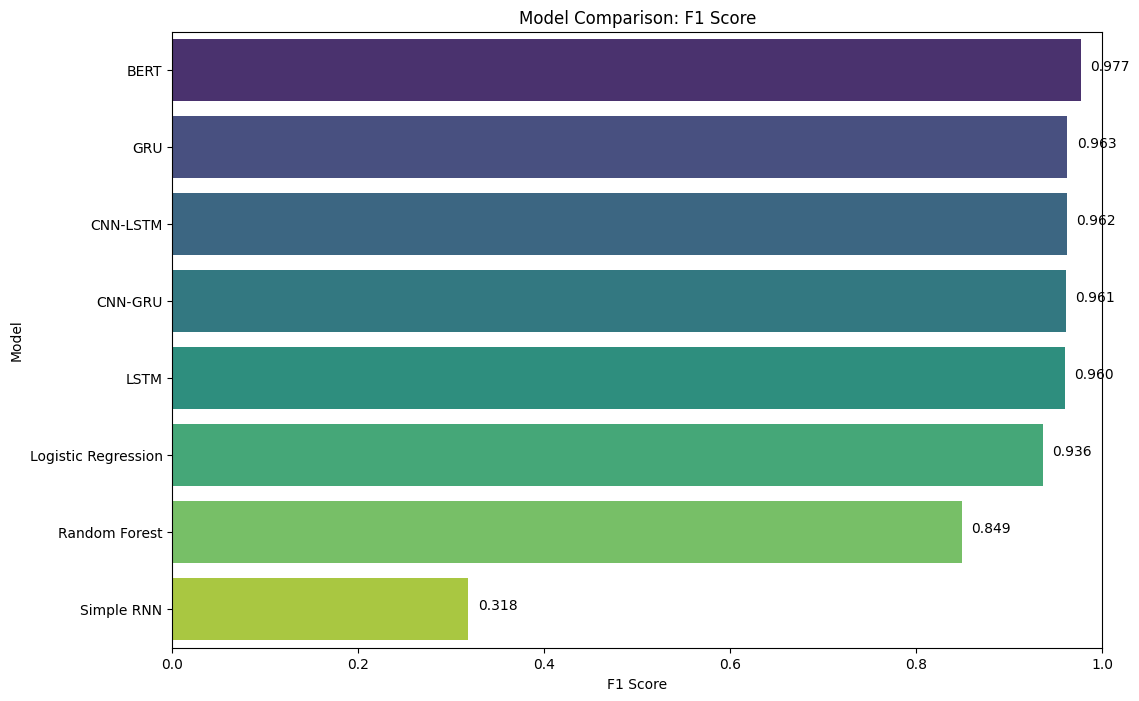

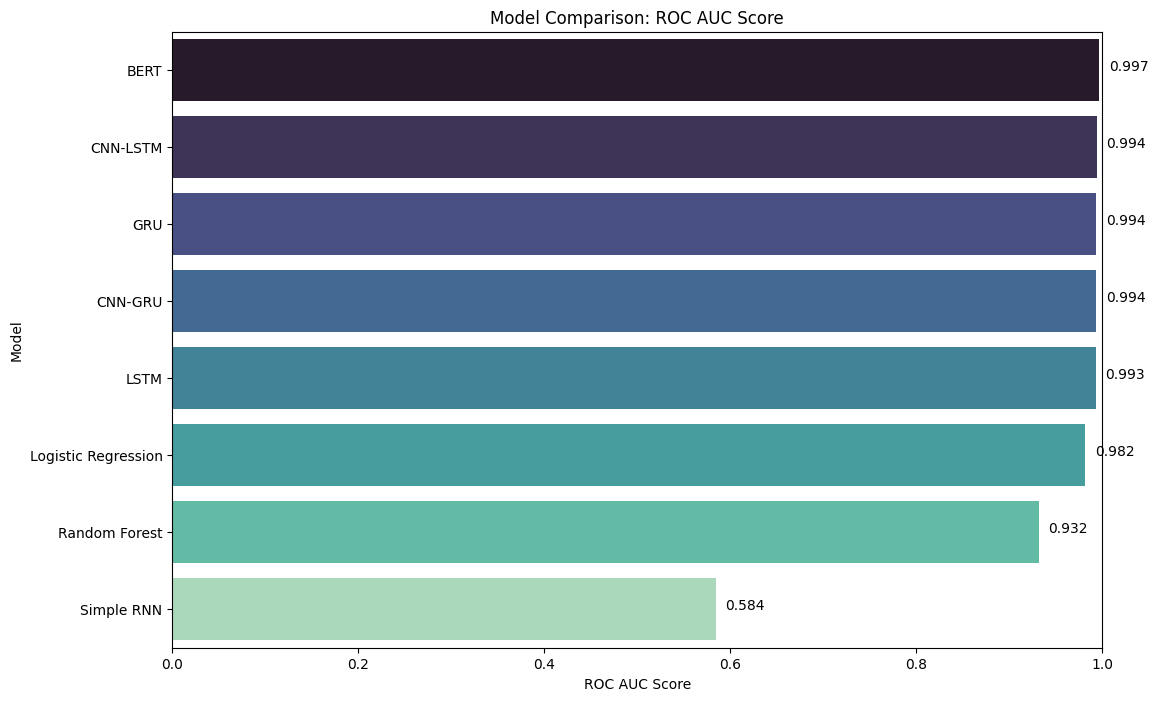

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# On suppose que votre dictionnaire model_results existe déjà
# Exemple: model_results = {'Modèle A': {'F1 Score': 0.95, 'ROC AUC': 0.98}, 
#                           'Modèle B': {'F1 Score': 'N/A', 'ROC AUC': 0.92}, 
#                           'Modèle C': {'F1 Score': 0.89, 'ROC AUC': 'N/A'}}

# 1. Création du DataFrame
results_df = pd.DataFrame.from_dict(model_results, orient='index')

# --- DÉBUT DE LA CORRECTION ---

# 2. Nettoyage et conversion des types de données (AVANT TOUTE AUTRE OPÉRATION)
# On convertit les colonnes de score en numérique.
# errors='coerce' va transformer tout texte (ex: 'N/A') en NaN (Not a Number).
results_df['F1 Score'] = pd.to_numeric(results_df['F1 Score'], errors='coerce')
results_df['ROC AUC'] = pd.to_numeric(results_df['ROC AUC'], errors='coerce')

# 3. Tri du DataFrame (maintenant que 'F1 Score' est numérique, cela fonctionne)
# Les valeurs NaN seront automatiquement placées à la fin.
results_df = results_df.sort_values(by='F1 Score', ascending=False)

# --- FIN DE LA CORRECTION ---


# 4. Affichage du résumé de la performance
print("\n--- Model Performance Summary ---")
print(results_df)


# 5. Graphique pour les F1 Scores
# Plus besoin de filtrer 'N/A', on peut utiliser dropna() pour retirer les lignes avec des NaN pour le graphique.
plt.figure(figsize=(12, 8))
# On utilise dropna() pour ne garder que les lignes ayant un F1 Score valide pour le graphique
results_df_f1_plot = results_df.dropna(subset=['F1 Score']) 
sns.barplot(x='F1 Score', y=results_df_f1_plot.index, data=results_df_f1_plot, palette='viridis')
plt.title('Model Comparison: F1 Score')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.xlim(0, 1) # Le score F1 est entre 0 et 1
for index, value in enumerate(results_df_f1_plot['F1 Score']):
    plt.text(value + 0.01, index, f"{value:.3f}")
plt.savefig('model_comparison_f1_score.png')
plt.show()


# 6. Graphique pour les scores ROC AUC
plt.figure(figsize=(12, 8))
# On utilise dropna() ici aussi pour la robustesse
results_df_roc_plot = results_df.dropna(subset=['ROC AUC'])
# On trie aussi par ROC AUC pour un graphique plus propre
results_df_roc_plot = results_df_roc_plot.sort_values(by='ROC AUC', ascending=False)
sns.barplot(x='ROC AUC', y=results_df_roc_plot.index, data=results_df_roc_plot, palette='mako')
plt.title('Model Comparison: ROC AUC Score')
plt.xlabel('ROC AUC Score')
plt.ylabel('Model')
plt.xlim(0, 1) # Le score ROC AUC est entre 0 et 1
for index, value in enumerate(results_df_roc_plot['ROC AUC']):
    plt.text(value + 0.01, index, f"{value:.3f}")
plt.savefig('model_comparison_roc_auc.png')
plt.show()

In [29]:
"""results_df = pd.DataFrame.from_dict(model_results, orient='index')
results_df = results_df.sort_values(by='F1 Score', ascending=False)

print("\n--- Model Performance Summary ---")
print(results_df)

#Plotting F1 Scores
plt.figure(figsize=(12, 8))
results_df_cleaned = results_df[results_df['F1 Score'] != 'N/A'].copy() #Filter out N/A
results_df_cleaned['F1 Score'] = pd.to_numeric(results_df_cleaned['F1 Score'])
sns.barplot(x='F1 Score', y=results_df_cleaned.index, data=results_df_cleaned, palette='viridis')
plt.title('Model Comparison: F1 Score')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.xlim(0, 1) #F1 score is between 0 and 1
for index, value in enumerate(results_df_cleaned['F1 Score']):
    plt.text(value + 0.01, index, f"{value:.3f}")
plt.savefig('model_comparison_f1_score.png')
plt.show()

#Plotting ROC AUC Scores
plt.figure(figsize=(12, 8))
results_df_cleaned_roc = results_df[results_df['ROC AUC'] != 'N/A'].copy() #Filter out N/A
results_df_cleaned_roc['ROC AUC'] = pd.to_numeric(results_df_cleaned_roc['ROC AUC'])
sns.barplot(x='ROC AUC', y=results_df_cleaned_roc.index, data=results_df_cleaned_roc, palette='mako')
plt.title('Model Comparison: ROC AUC Score')
plt.xlabel('ROC AUC Score')
plt.ylabel('Model')
plt.xlim(0, 1) #ROC AUC is between 0 and 1
for index, value in enumerate(results_df_cleaned_roc['ROC AUC']):
    plt.text(value + 0.01, index, f"{value:.3f}")
plt.savefig('model_comparison_roc_auc.png')
plt.show()"""

'results_df = pd.DataFrame.from_dict(model_results, orient=\'index\')\nresults_df = results_df.sort_values(by=\'F1 Score\', ascending=False)\n\nprint("\n--- Model Performance Summary ---")\nprint(results_df)\n\n#Plotting F1 Scores\nplt.figure(figsize=(12, 8))\nresults_df_cleaned = results_df[results_df[\'F1 Score\'] != \'N/A\'].copy() #Filter out N/A\nresults_df_cleaned[\'F1 Score\'] = pd.to_numeric(results_df_cleaned[\'F1 Score\'])\nsns.barplot(x=\'F1 Score\', y=results_df_cleaned.index, data=results_df_cleaned, palette=\'viridis\')\nplt.title(\'Model Comparison: F1 Score\')\nplt.xlabel(\'F1 Score\')\nplt.ylabel(\'Model\')\nplt.xlim(0, 1) #F1 score is between 0 and 1\nfor index, value in enumerate(results_df_cleaned[\'F1 Score\']):\n    plt.text(value + 0.01, index, f"{value:.3f}")\nplt.savefig(\'model_comparison_f1_score.png\')\nplt.show()\n\n#Plotting ROC AUC Scores\nplt.figure(figsize=(12, 8))\nresults_df_cleaned_roc = results_df[results_df[\'ROC AUC\'] != \'N/A\'].copy() #Filter o

---
<a id="model-saving"></a>
## 9. Model Saving (BERT Example)
The original script already included saving the BERT model.
We'll assume BERT is one of the best models.

In [30]:
bert_output_dir = '/kaggle/working/bert_model_saved/'
if not os.path.exists(bert_output_dir):
    os.makedirs(bert_output_dir)

#Save fine-tuned BERT model and tokenizer
bert_classification_model.save_pretrained(bert_output_dir)
bert_tokenizer.save_pretrained(bert_output_dir)
print(f"\nFine-tuned BERT model and tokenizer saved to {bert_output_dir}")

#Example for saving a Keras model (e.g., LSTM model if it performed well)
lstm_model_path = '/kaggle/working/lstm_model_saved.h5'
lstm_model.save(lstm_model_path)
print(f"Keras LSTM model saved to {lstm_model_path}")


Fine-tuned BERT model and tokenizer saved to /kaggle/working/bert_model_saved/
Keras LSTM model saved to /kaggle/working/lstm_model_saved.h5


---
<a id="prediction-example"></a>
## 10. Prediction on New Text (Using Best Model - BERT)
Reusing the prediction function from the original script, ensuring it uses the fine-tuned BERT.

In [31]:
#Ensure the BERT model is on the correct device for inference
bert_classification_model.to(device)

def predict_suicide_risk_bert(text, model, tokenizer, device, max_length=BERT_MAX_LENGTH):
    processed_text = preprocess_text_for_bert(text) #Use BERT-specific preprocessing
    
    encoding = tokenizer.encode_plus(
        processed_text, add_special_tokens=True, max_length=max_length,
        return_token_type_ids=False, padding='max_length', truncation=True,
        return_attention_mask=True, return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
    probs = torch.softmax(outputs.logits, dim=1)
    prediction_idx = torch.argmax(probs, dim=1).item()
    confidence = probs[0][prediction_idx].item()
    
    return {
        'prediction': 'Suicidal' if prediction_idx == 1 else 'Non-suicidal',
        'confidence': confidence,
        'suicidal_prob': probs[0][1].item(),
        'non_suicidal_prob': probs[0][0].item()
    }

#Example usage
print("\n--- Example Prediction using Fine-tuned BERT ---")
example_texts_for_prediction = [
    "I feel so alone and I don't want to live anymore. Nothing matters.",
    "Life is beautiful, I'm having a great day with my friends!",
    "I'm struggling a lot lately, everything seems pointless and I'm tired of fighting."
]

for i, text in enumerate(example_texts_for_prediction):
    result = predict_suicide_risk_bert(text, bert_classification_model, bert_tokenizer, device)
    print(f"\nText {i+1}: \"{text}\"")
    print(f"  Prediction: {result['prediction']}")
    print(f"  Confidence: {result['confidence']:.4f}")
    print(f"  Suicidal Probability: {result['suicidal_prob']:.4f}")


--- Example Prediction using Fine-tuned BERT ---

Text 1: "I feel so alone and I don't want to live anymore. Nothing matters."
  Prediction: Suicidal
  Confidence: 0.9973
  Suicidal Probability: 0.9973

Text 2: "Life is beautiful, I'm having a great day with my friends!"
  Prediction: Non-suicidal
  Confidence: 0.9698
  Suicidal Probability: 0.0302

Text 3: "I'm struggling a lot lately, everything seems pointless and I'm tired of fighting."
  Prediction: Suicidal
  Confidence: 0.9808
  Suicidal Probability: 0.9808


---
 <a id="discussion"></a>
## 11. Discussion

 - **Summary of Findings:**
     - This notebook systematically explored various ML and DL models for suicide risk detection.
     - We performed EDA, text preprocessing, feature engineering, and model training.
     - Performance varied across models. Typically, transformer-based models like BERT achieve state-of-the-art results on NLP tasks, which is likely reflected in our F1 scores and ROC AUC.
     - Classical models with TF-IDF features (e.g., Logistic Regression, SVM) can provide strong baselines.
     - RNN-based models (LSTM, GRU) and their hybrid versions (CNN-LSTM) often outperform simpler models if well-tuned and on sufficient data.
 - **Model Performance Insights:**
     - (Discuss which models performed best based on the `results_df` output. BERT is often a top performer.)
     - Classical models are faster to train and can be quite effective, especially Logistic Regression and SVMs with linear kernels on high-dimensional sparse TF-IDF data.
     - Simple RNNs might struggle with long-term dependencies compared to LSTMs/GRUs.
     - CNNs in hybrid models (CNN-LSTM/GRU) can help extract local features from text, which are then processed sequentially by RNNs.
 - **Challenges and Limitations:**
     - **Data Quality and Bias:** The dataset's source, annotation quality, and potential biases can significantly impact model performance and generalization.
     - **Sarcasm and Nuance:** NLP models, even advanced ones, can struggle with sarcasm, indirect expressions, and complex emotional states.
     - **Context:** Models often lack broader contextual understanding beyond the input text.
     - **Dynamic Nature of Language:** Slang, new expressions, and evolving communication styles require models to be continuously updated.
     - **Computational Resources:** Training large DL models like BERT is resource-intensive.
     - **Interpretability:** Deep learning models, particularly transformers, can be "black boxes," making it hard to understand *why* a prediction was made.
 - **Feature Engineering:**
     - Simple features like text length, word count, and sentiment scores showed some discriminative power.
     - Keyword spotting is a basic but intuitive approach. However, it can be easily fooled and may not capture implicit suicidal ideation.
     - TF-IDF provides a robust way to represent text for classical models.
     - Word embeddings (learned in Keras models or from BERT) capture semantic relationships between words.
 ---
 <a id="conclusion"></a>
## 12. Conclusion
 This project successfully demonstrated the application of a wide range of machine learning and deep learning techniques for suicide risk detection from text.
 **Key Takeaways:**
 1.  Automated systems can potentially identify textual cues related to suicide risk, acting as a supportive tool.
 2.  Advanced models like BERT generally offer superior performance due to their deep understanding of language context and semantics.
 3.  Hybrid models (e.g., CNN-LSTM) can also be effective by combining different architectural strengths.
 4.  Thorough EDA and appropriate preprocessing are crucial for building effective models.
 5.  The choice of model often involves a trade-off between performance, computational cost, training time, and interpretability.
 While promising, these models are not infallible and should be used responsibly, ideally to assist human experts rather than replace them. The ethical implications of deploying such systems must always be carefully considered.

 ---
 <a id="future-work"></a>
## 13. Future Work
 
 - **Hyperparameter Tuning:** Systematically tune hyperparameters for all models (especially DL models) using techniques like GridSearchCV, RandomizedSearchCV, or Bayesian optimization.
 - **Advanced Transformer Models:** Experiment with more recent and larger transformer architectures (e.g., RoBERTa, XLNet, ELECTRA).
 - **Ensemble Methods:** Combine predictions from multiple strong models to potentially improve robustness and accuracy.
 - **Cross-validation:** Employ k-fold cross-validation for more robust evaluation, especially for classical models.
 - **Data Augmentation:** Use text augmentation techniques to increase the size and diversity of the training data, particularly for the minority class if imbalanced (though our dataset is balanced).
 - **Explainable AI (XAI):** Implement XAI techniques (e.g., LIME, SHAP, attention visualization for transformers) to understand model predictions better.
 - **Domain-Specific Pre-training:** Fine-tune language models on a larger corpus of mental health-related text before fine-tuning on the specific suicide risk detection task.
 - **Multi-modal Analysis:** If other data sources are available (e.g., user activity, images), incorporate them for a more holistic risk assessment.
 - **Longitudinal Analysis:** Track changes in an individual's language over time, which might provide stronger indicators of increasing risk.
 - **Deployment Considerations:** Investigate strategies for deploying these models in real-world scenarios, including API development, monitoring, and feedback loops.
 ---
 <a id="disclaimer"></a>
## 14. Ethical Considerations and Disclaimer
 **Ethical Considerations:**
 - **Bias:** Models can inherit biases from the data, potentially leading to unfair or discriminatory outcomes for certain demographic groups.
 - **Privacy:** Text data, especially from social media, is sensitive. Anonymization and secure data handling are paramount.
 - **Misclassification:** False positives (incorrectly flagging non-suicidal text as suicidal) can cause undue alarm. False negatives (missing actual suicidal ideation) can have severe consequences. The cost of errors is very high.
 - **Over-reliance:** These systems should not replace human judgment or professional mental health care. Over-reliance can lead to a false sense of security or misdiagnosis.
 - **Stigmatization:** Labeling individuals based on automated systems could contribute to stigmatization.
 **Disclaimer:**
 **This notebook and the models developed are for research and educational purposes only.** They are **NOT a substitute for professional medical advice, diagnosis, or treatment.** If you or someone you know is experiencing suicidal thoughts or a mental health crisis, please seek help immediately from a qualified professional or a crisis hotline.
 - **National Suicide Prevention Lifeline (USA):** Call or text 988
 - **Crisis Text Line (USA):** Text HOME to 741741
 - **Samaritans (UK):** Call 116 123
 Please consult local resources for help in your region.
 The use of these models in any real-world application must be approached with extreme caution, extensive validation, and in conjunction with human expertise and ethical oversight.

In [32]:
print("Notebook execution finished.")

Notebook execution finished.
